### 【問題1】クロスバリデーション

In [2]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
pd.set_option('display.max_columns', 130) #カラムの表示を省略されないように１００に設定

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score


In [3]:
from sklearn.metrics import roc_curve
from sklearn import metrics

def get_auc_and_roc_curve(y_test,y_pred):
    
    """
    aucを返します。
    ROC曲線をプロットします。
    """

    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    auc = metrics.a
    uc(fpr, tpr)
    #print("aucは%.4fです"%auc)
    
    # ROC曲線をプロット
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    
    return auc

def get_auc(y_test,y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    return auc

In [4]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

def print_auc_lgb(df_train, params=None):
    #lgbmで学習後、pred、aucをプリントします。ついでにモデルをリターンします。
    
    X = df_train.drop("TARGET", axis=1).values #valursでarrayに変換
    y = df_train["TARGET"].values
    #スプリット
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=49)
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    #lgbmでモデル作成
    if params:
        lgb_params = params
    else:
        lgb_params = {'objective':'binary', 
                 'boosting_type': 'rf',
                 'subsample': 0.623,
                  'colsample_bytree': 0.7,
                  'num_leaves': 127,
                  'max_depth': 8,
                  'seed': 99,
                  'bagging_freq': 1,
                  'n_jobs': 4,}
                                
    model_lgb = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval)
    
     #プレッド
    y_pred_test = model_lgb.predict(X_test)
    y_pred_train = model_lgb.predict(X_train)
    #aucを取得
    auc_test = get_auc(y_test,y_pred_test)
    auc_train = get_auc(y_train,y_pred_train)

    result = [auc_test,auc_train]
    
    print(result)
    
    return model_lgb

In [5]:
from sklearn.metrics import mean_squared_error

def missing_value_prediction(df1,columns):
    #columnsの欠損値を予測し、欠損値を埋めたdfを返す。
    
    #TARGETは予測に含めないので落とす
    df = df1.drop("TARGET", axis=1)
    
    #予測対象の抜き出し
    df_target = df[df[columns].isnull()]
    X_target = df_target.drop(columns, axis=1).values
    
    # columnsの欠損がない行を抜き出し subsetに対象とする行
    df_train = df.dropna(subset=[columns])
    X = df_train.drop(columns, axis=1).values #valursでarrayに変換
    y = df_train[columns].values
    
    #スプリット
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=49)
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    #回帰でモデル作成
    lgb_params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'regression',
        'metric' : {'l2'},
        'num_leaves' : 31,
        'learning_rate' : 0.1,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : 0
}
                                
    model_lgb = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval)

     #プレッド
    y_pred = model_lgb.predict(X_target)
    y_test_pred = model_lgb.predict(X_test)
    
    print("テストの二乗平均平方根誤差 (RMSE)は")
    print(np.sqrt(mean_squared_error(y_test, y_test_pred)))#二乗平均平方根誤差 (RMSE)
    
    indexer = df1[columns].isnull()
    new_df = df1.copy()
    new_df.loc[indexer, columns] = y_pred

    return new_df

In [6]:
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

In [7]:
#特徴量の追加
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

### Train Dataset

In [8]:
# get the train dataset

df_train = pd.read_csv('application_train.csv')

df_train = df_train.sample(100000)

In [25]:
# grasp the contents of the train dataset

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 170199 to 96623
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 93.8+ MB


In [26]:
df_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL                      int64
FLAG_EMP_PHONE                  int64
FLAG_WORK_PHONE                 int64
FLAG_CONT_MOBILE                int64
FLAG_PHONE  

In [27]:
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,99998.000000,9.989800e+04,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,33954.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,43400.000000,99781.000000,80157.000000,49301.000000,41534.000000,51273.000000,33548.000000,30180.000000,46721.000000,49704.000000,50303.000000,32197.000000,40681.000000,31663.000000,49873.000000,30656.000000,44877.000000,49301.000000,41534.000000,51273.000000,33548.000000,30180.000000,46721.000000,49704.000000,50303.000000,32197.000000,40681.000000,31663.000000,49873.000000,30656.000000,44877.000000,49301.000000,41534.000000,51273.000000,33548.000000,30180.000000,46721.000000,49704.000000,50303.000000,32197.000000,40681.000000,31663.000000,49873.000000,30656.000000,44877.000000,51790.000000,99680.000000,99680.000000,99680.000000,99680.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,86531.000000,86531.000000,86531.000000,86531.000000,86531.000000,86531.000000
mean,278565.813490,0.080020,0.415390,1.682189e+05,5.996738e+05,27085.877288,5.388307e+05,0.020842,-16041.463990,63967.657050,-4980.081500,-2995.453170,12.045974,1.0,0.819480,0.198630,0.998110,0.283270,0.05715,2.150180,2.052720,2.03241,12.052150,0.01516,0.050720,0.040570,0.078040,0.229700,0.178860,0.502229,0.514476,0.510903,0.117616,0.088462,0.977757,0.751689,0.044158,0.078808,0.149963,0.226384,0.232334,0.066504,0.101008,0.107381,0.008762,0.028828,0.114390,0.087499,0.977104,0.758899,0.042075,0.074357,0.145534,0.222456,0.228723,0.065109,0.105901,0.105996,0.007971,0.027473,0.118023,0.087998,0.977785,0.754941,0.044133,0.077997,0.149461,0.226067,0.232224,0.067395

In [28]:
# check whether each feature value has missing values of the train dataset

n_missing_values = df_train.isnull().sum().drop("SK_ID_CURR").drop("TARGET")

n_missing_values_table = pd.DataFrame({
    'missing_values': n_missing_values
})

n_missing_values_table

,missing_values
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,2
AMT_GOODS_PRICE,102
NAME_TYPE_SUITE,442


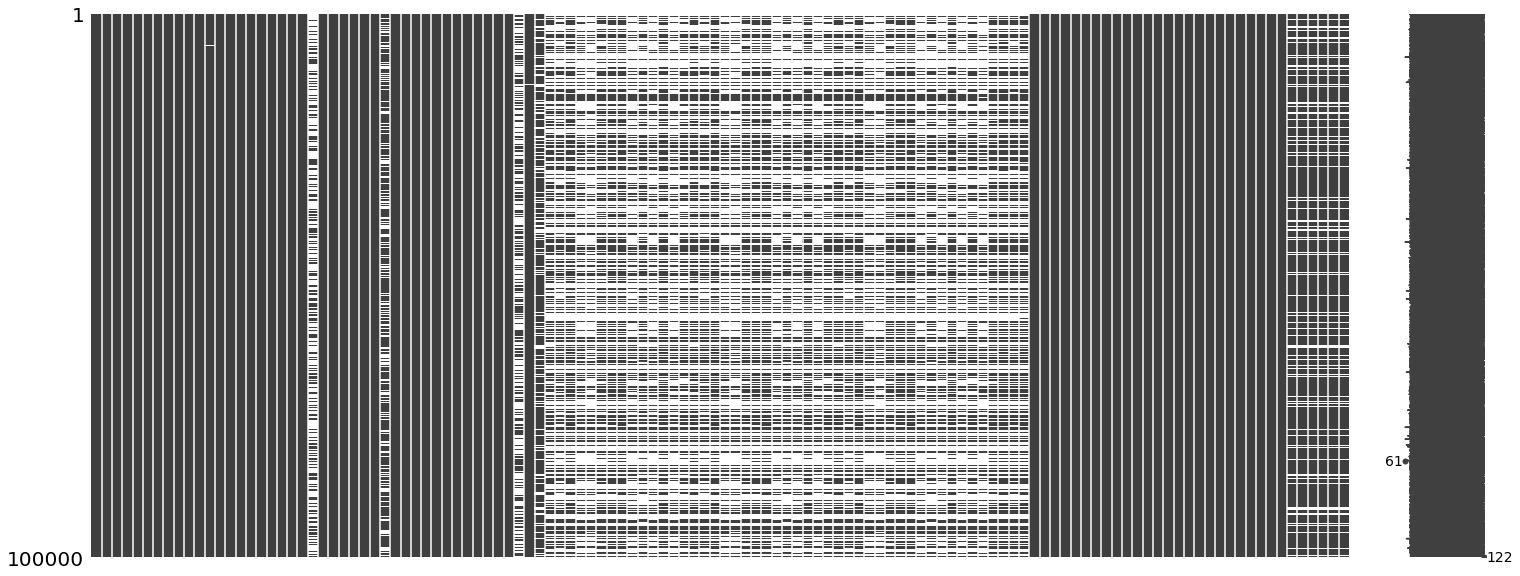

In [29]:
msno.matrix(df_train)

plt.show()

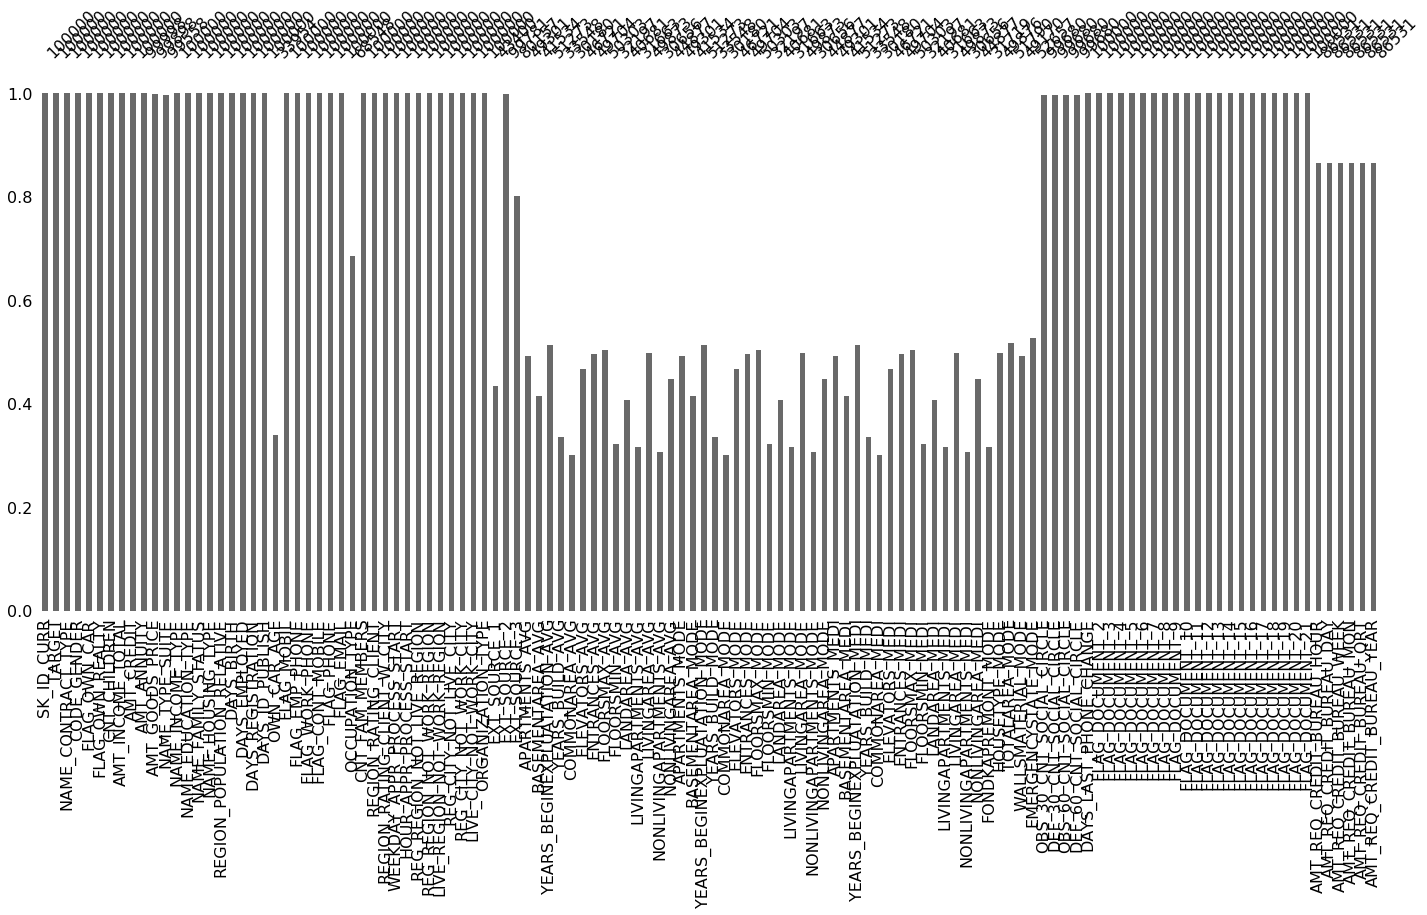

In [30]:
msno.bar(df_train)

plt.show()

### Test Dataset

In [9]:
# get the test dataset

df_test = pd.read_csv('application_test.csv')

df_test.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Marr

In [32]:
# grasp the contents of the test dataset

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [34]:
df_test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,16432.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,28212.000000,48736.000000,40076.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,26120.000000,48715.000000,48715.000000,48715.000000,48715.000000,48744.000000,48744.0,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,48744.0,48744.0,48744.0,48744.0,48744.0,48744.0,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,-3051.712949,11.786027,0.999979,0.809720,0.204702,0.998400,0.263130,0.162646,2.146767,2.038159,2.012596,12.007365,0.018833,0.055166,0.042036,0.077466,0.224664,0.174216,0.501180,0.518021,0.500106,0.122388,0.090065,0.978828,0.751137,0.047624,0.085168,0.151777,0.233706,0.238423,0.067192,0.105885,0.112286,0.009231,0.029387,0.119078,0.088998,0.978292,0.758327,0.045223,0.080570,0.147161,0.229390,0.233854,0.065914,0.110874,0.110687,0.008358,0.028161,0.122809,0.089529,0.978822,0.754344,0.047420,0.084128,0.151200,0.233154,0.237846,0.068069,0.107063,0.113368,0.008979,0.029296,0.107129,1.447644,0.143652,1.435738,0.101139,-1077.766228,0.0,0.786620,

In [35]:
# check whether each feature value has missing values of the test dataset

df_test_n_missing_values = df_test.isnull().sum().drop("SK_ID_CURR")

df_test_n_missing_values_table = pd.DataFrame({
    'missing_values': df_test_n_missing_values
})

df_test_n_missing_values_table

,missing_values
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,24
AMT_GOODS_PRICE,0
NAME_TYPE_SUITE,911


### Concatenated Dataset

In [10]:
# concatenate the train dataset with the test dataset

df_train_test = df_train.append(df_test)

df_train_test

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
70718,38331.0,1078200.0,900000.0,90000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,M,NaN,NaN,NaN,-13105,-694,-3711,-303.0,-385.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.283391,0.855000,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,N,N,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Cash loans,Secondary / secondary special,Married,House / apartment,Commercial associate,Unaccompanied,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Laborers,Self-employed,NaN,0.019101,2,2,0,0,0,0,182029,0.0,NaN,NaN,TUESDAY,NaN,NaN,NaN,NaN,NaN,NaN
81115,26833.5,225000.0,225000.0,270000.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,M,NaN,NaN,NaN,-18871,-482,-2408,0.0,-7378.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598748,0.470456,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,Y,Y,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,Cash loans,Secondary / secondary special,Married,House / apartment,Working,Unaccompanied,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,Drivers,Self-employed,4.0,0.026392,2,2,0,1,0,0,194047,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN
292932,24961.5,251091.0,238500.0,135000.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0340,0.0344,0.0347,0.0864,0.0864,0.0896,0,2.0,M,0.0071,0.0071,0.0071,-22359,-803,-4549,-575.0,-9259.0,0.0,0.0,NaN,NaN,NaN,No,0.1724,0.1724,0.1724,NaN,0.622893,0.231439,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,N,Y,0,0,0.1250,0.1250,0.1250,NaN,NaN,NaN,NaN,17,block of flats,0.0733,0.0746,0.0750,0,0,0.0269,0.0274,0.0294,0.0445,0.0453,0.0463,Cash loans,Secondary / secondary special,Married,House / apartment,Commercial associate,Unaccompanied,0.0039,0.0039,0.0039,0.0527,0.0538,0.0558,0.0,0.0,Laborers,Business Entity Type 2,NaN,0.018850,2,2,0,0,0,0,439366,0.0,0.0503,"Stone, brick",WEDNESDAY,0.9652,0.9652,0.9652,0

In [11]:
#文字列の欠損は欠損のグループを作成する
#getdummies
df_train_test2 = pd.get_dummies(df_train_test, dummy_na=True)

#欠損値の穴埋め、回帰

df_train_test3 = missing_value_prediction(df_train_test2,"EXT_SOURCE_1")
df_train_test4 = missing_value_prediction(df_train_test3,"EXT_SOURCE_3")

[1]	valid_0's l2: 0.0414873
[2]	valid_0's l2: 0.038517
[3]	valid_0's l2: 0.0361045
[4]	valid_0's l2: 0.0341264
[5]	valid_0's l2: 0.0331805
[6]	valid_0's l2: 0.0317531
[7]	valid_0's l2: 0.0305813
[8]	valid_0's l2: 0.0296106
[9]	valid_0's l2: 0.0288278
[10]	valid_0's l2: 0.0281617
[11]	valid_0's l2: 0.0276255
[12]	valid_0's l2: 0.0271698
[13]	valid_0's l2: 0.0267931
[14]	valid_0's l2: 0.0264831
[15]	valid_0's l2: 0.0262226
[16]	valid_0's l2: 0.025991
[17]	valid_0's l2: 0.0257911
[18]	valid_0's l2: 0.0256155
[19]	valid_0's l2: 0.0254768
[20]	valid_0's l2: 0.0253557
[21]	valid_0's l2: 0.0252421
[22]	valid_0's l2: 0.0251507
[23]	valid_0's l2: 0.0250741
[24]	valid_0's l2: 0.0249996
[25]	valid_0's l2: 0.0249377
[26]	valid_0's l2: 0.0248742
[27]	valid_0's l2: 0.0248171
[28]	valid_0's l2: 0.0247718
[29]	valid_0's l2: 0.0247316
[30]	valid_0's l2: 0.0246935
[31]	valid_0's l2: 0.0246482
[32]	valid_0's l2: 0.0246103
[33]	valid_0's l2: 0.0245813
[34]	valid_0's l2: 0.0245563
[35]	valid_0's l2: 0.0245

In [38]:
# grasp the contents of the concatenated dataset

df_train_test4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148744 entries, 170199 to 48743
Columns: 261 entries, AMT_ANNUITY to WEEKDAY_APPR_PROCESS_START_nan
dtypes: float64(66), int64(40), uint8(155)
memory usage: 143.4 MB


In [39]:
df_train_test4.describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,...,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan
count,148718.000000,1.487440e+05,1.486420e+05,1.487440e+05,129226.000000,129226.000000,129226.000000,129226.000000,129226.000000,129226.000000,74158.000000,74158.000000,74158.000000,62637.000000,62637.000000,62637.000000,148744.000000,148744.000000,45429.000000,45429.000000,45429.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148395.000000,148395.000000,70276.00000,70276.000000,70276.000000,74869.000000,74869.000000,74869.000000,148744.000000,148517.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.0,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,148744.000000,75726.000000,75726.000000,...,148744.00

In [40]:
# check whether each feature value has missing values of the concatenated dataset

df_train_test4_n_missing_values = df_train_test4.isnull().sum().drop("SK_ID_CURR")

df_train_test4_n_missing_values_table = pd.DataFrame({
    'missing_values': df_train_test4_n_missing_values
})

df_train_test4_n_missing_values_table

,missing_values
AMT_ANNUITY,26
AMT_CREDIT,0
AMT_GOODS_PRICE,102
AMT_INCOME_TOTAL,0
AMT_REQ_CREDIT_BUREAU_DAY,19518
AMT_REQ_CREDIT_BUREAU_HOUR,19518
AMT_REQ_CREDIT_BUREAU_MON,19518
AMT_REQ_CREDIT_BUREAU_QRT,19518
AMT_REQ_CREDIT_BUREAU_WEEK,19518
AMT_REQ_CREDIT_BUREAU_YEAR,19518


In [41]:
#  compute all correlation coefficients of the new dataset containing dummies

corr_mat = df_train_test4.corr()

corr_mat

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,...,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan
AMT_ANNUITY,1.000000,0.757643,0.764103,0.458269,-0.002937,0.000960,0.019247,0.028578,0.003854,-0.025444,0.081180,0.078664,0.072200,0.046387,0.044350,0.036780,0.032310,0.086899,0.066495,0.064967,0.059313,0.022730,-0.118211,0.022374,-0.059349,0.047575,-0.021365,-0.023948,0.107923,0.105873,0.100729,0.016432,0.015021,0.009896,0.073240,0.124371,0.026952,0.028367,-0.004330,-0.001482,NaN,0.016809,0.028518,0.011651,-0.000201,0.004829,-0.013460,0.002370,0.000625,0.009113,-0.008491,0.067486,-0.002341,-0.005645,-0.077296,0.003608,0.130560,0.035553,0.083047,0.117471,-0.004844,0.002093,-0.033460,0.136207,0.135090,...,-0.000542,-0.006329,-0.001909,-0.001103,0.002677,-0.000012,-0.007423,-0.000682,-0.002137,-0.001332,-0.016674,0.005169,0.000156,0.000759,-0.000226,-0.000145,0.014497,0.005863,-0.019202,0.014324,-0.008383,0.026990,-0.005099,0.011101,0.021290,-0.022621,0.014960,0.001751,0.000167,-0.005879,-9.1

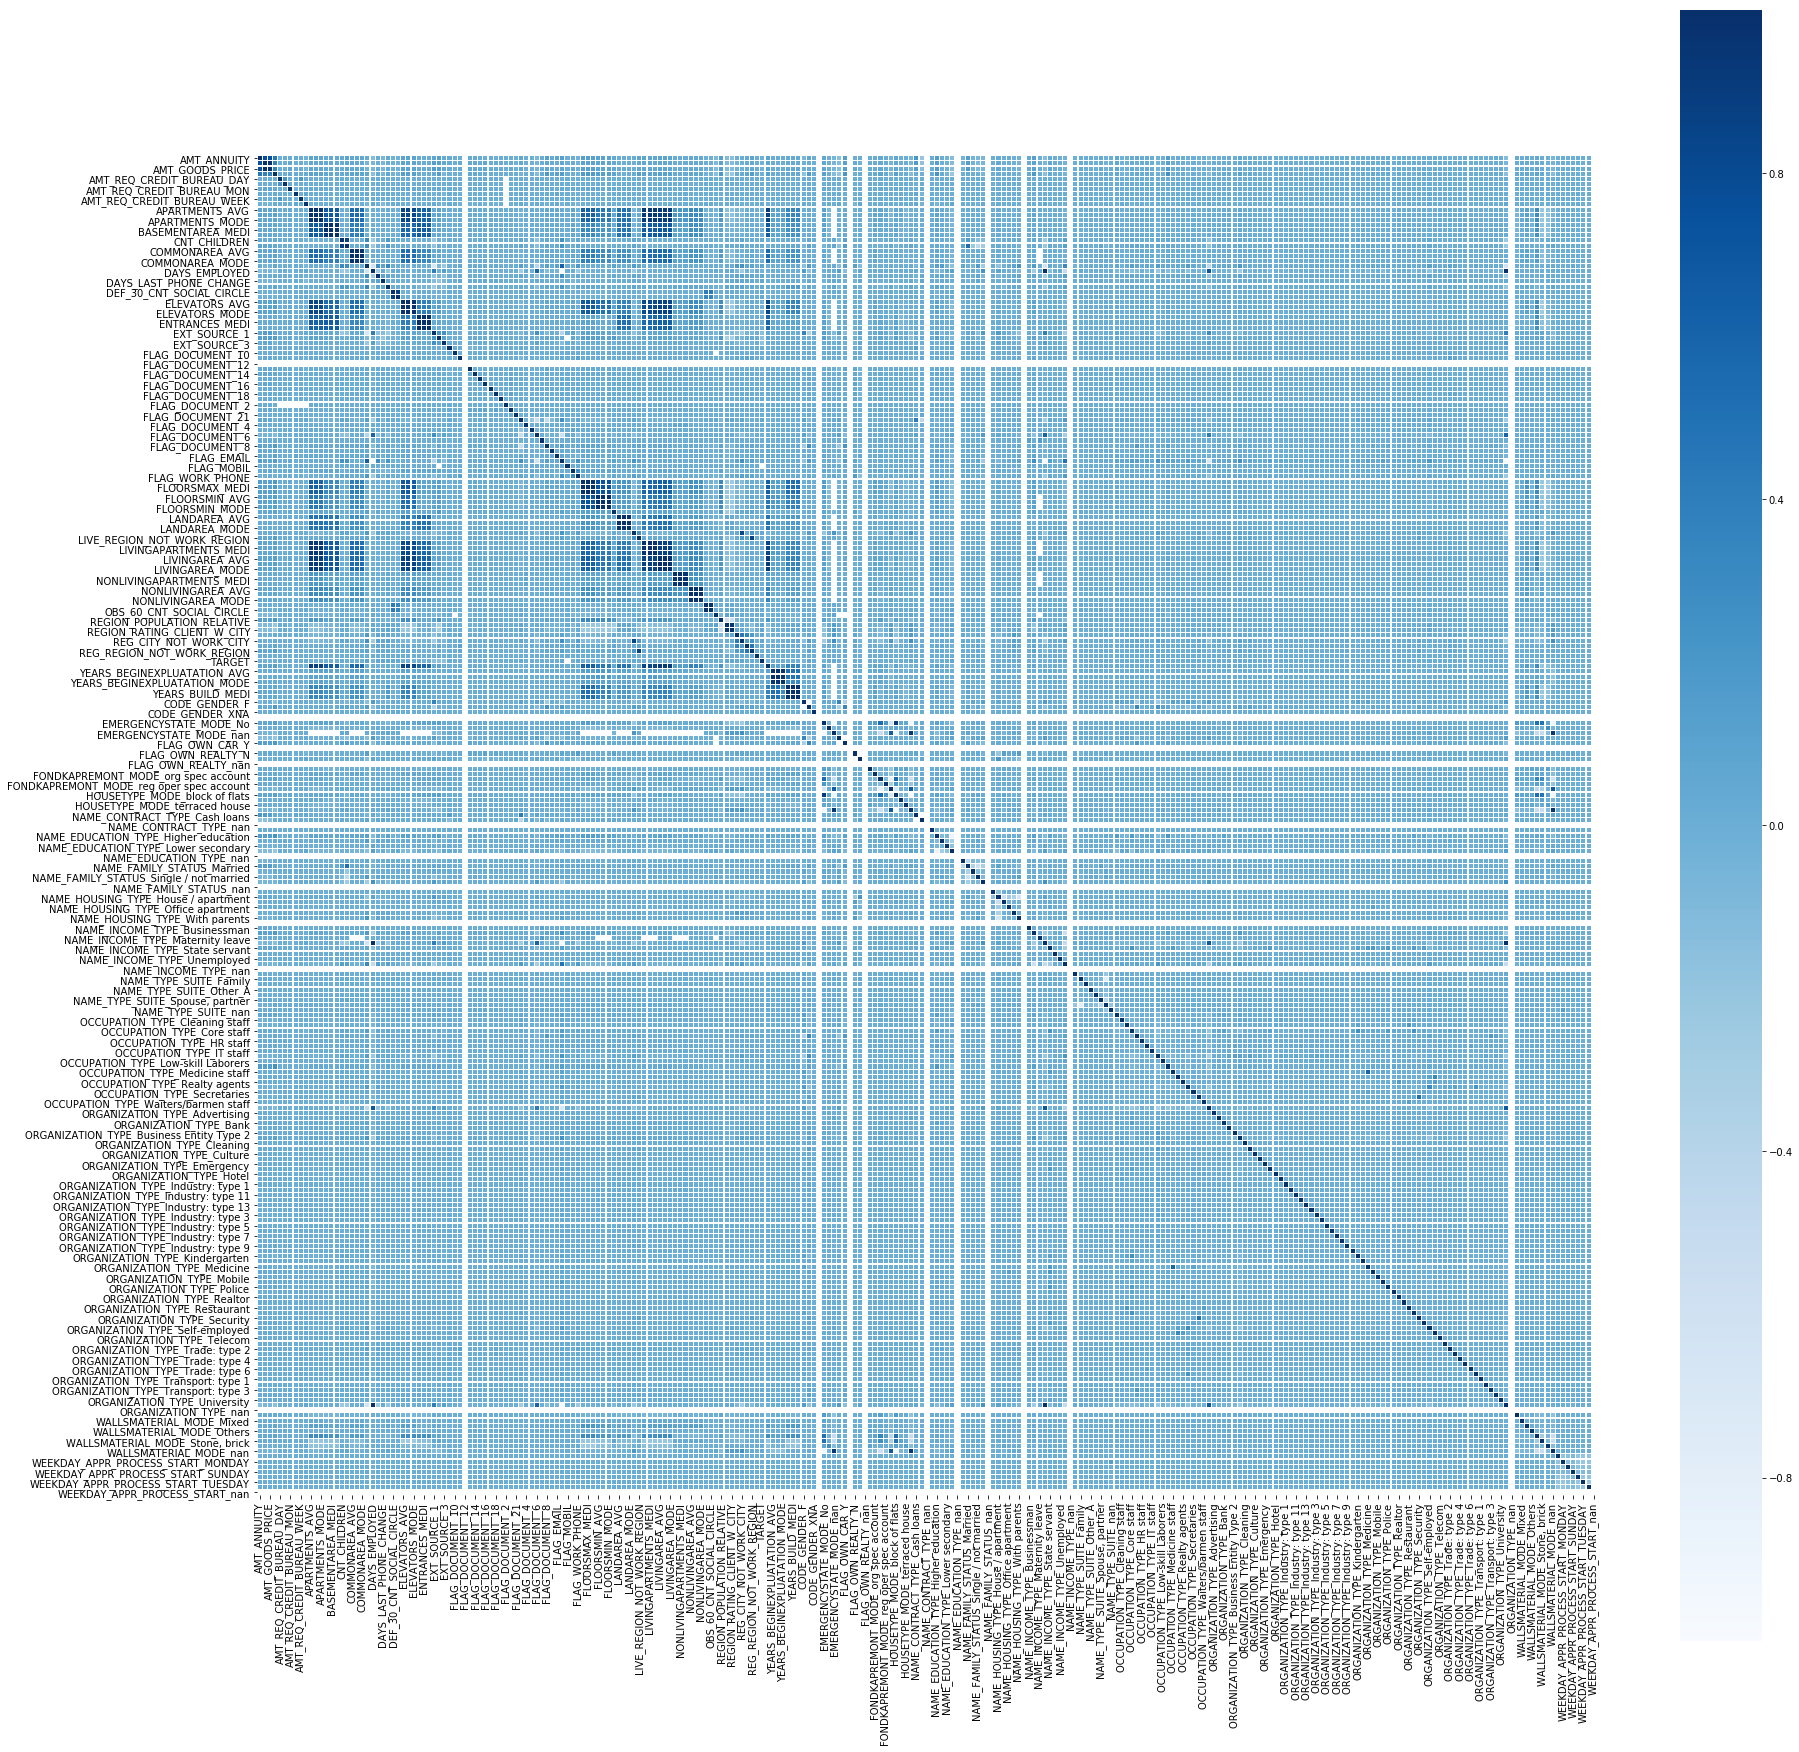

In [42]:
# create the heatmap

plt.figure(figsize=(30,30))
sns.heatmap(corr_mat, linewidth=0.1, square=True, cmap="Blues")

plt.show()

In [13]:
# split the concatenated dataset into the train dataset and the test dataset

df_train_dm = df_train_test4[0: df_train.shape[0]].copy()
print("train_ shape is", df_train_dm.shape)

df_test_dm = df_train_test4[df_train.shape[0]:].copy()
df_test_dm = df_test_dm.drop("TARGET", axis=1)
print("test_ shape is", df_test_dm.shape)

train_ shape is (100000, 261)
test_ shape is (48744, 260)


In [44]:
X = df_train_dm.drop("TARGET", axis=1).values
y = df_train_dm.loc[:,'TARGET'].values

In [45]:
# まずLithgbmのパイプラインを作る

lgb_train = lgb.Dataset(X,y)

In [46]:
lgb_eval = lgb.Dataset(X, y, reference=lgb_train)

In [47]:
lgb_params = {'objective':'binary',
               'boosting_type': 'rf',
               'subsample': 0.623,
               'colsample_bytree': 0.7,
               'num_leaves': 127,
               'max_depth': 8,
               'seed': 99,
               'bagging_freq': 1,
               'n_jobs': 4}


In [48]:
model = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval)

[1]	valid_0's binary_logloss: 0.262546
[2]	valid_0's binary_logloss: 0.247464
[3]	valid_0's binary_logloss: 0.244386
[4]	valid_0's binary_logloss: 0.24284
[5]	valid_0's binary_logloss: 0.242152
[6]	valid_0's binary_logloss: 0.24159
[7]	valid_0's binary_logloss: 0.241211
[8]	valid_0's binary_logloss: 0.240984
[9]	valid_0's binary_logloss: 0.240988
[10]	valid_0's binary_logloss: 0.24077
[11]	valid_0's binary_logloss: 0.240627
[12]	valid_0's binary_logloss: 0.24038
[13]	valid_0's binary_logloss: 0.240418
[14]	valid_0's binary_logloss: 0.240452
[15]	valid_0's binary_logloss: 0.24036
[16]	valid_0's binary_logloss: 0.240481
[17]	valid_0's binary_logloss: 0.240347
[18]	valid_0's binary_logloss: 0.240246
[19]	valid_0's binary_logloss: 0.240115
[20]	valid_0's binary_logloss: 0.240167
[21]	valid_0's binary_logloss: 0.240164
[22]	valid_0's binary_logloss: 0.24007
[23]	valid_0's binary_logloss: 0.239983
[24]	valid_0's binary_logloss: 0.239922
[25]	valid_0's binary_logloss: 0.239895
[26]	valid_0's 

In [49]:
y_pred = model.predict(X)

In [50]:
y_test_pred = model.predict(df_test_dm.values)

In [51]:
# def auc
def make_roc_curve (y_true, y_pred):
    from sklearn.metrics import roc_curve
    from sklearn import metrics

    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print('auc{}'.format(auc))

    # ROC
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    return auc

auc0.7875382115904969


0.7875382115904969

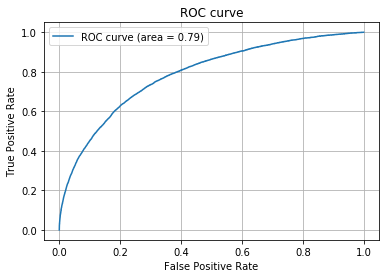

In [52]:
make_roc_curve(y, y_pred)

TRAIN: [20000 20001 20002 ... 99997 99998 99999] TEST: [    0     1     2 ... 19997 19998 19999]
[1]	valid_0's binary_logloss: 0.26775
[2]	valid_0's binary_logloss: 0.246176
[3]	valid_0's binary_logloss: 0.241874
[4]	valid_0's binary_logloss: 0.240893
[5]	valid_0's binary_logloss: 0.240042
[6]	valid_0's binary_logloss: 0.23954
[7]	valid_0's binary_logloss: 0.238965
[8]	valid_0's binary_logloss: 0.238786
[9]	valid_0's binary_logloss: 0.238417
[10]	valid_0's binary_logloss: 0.238103
[11]	valid_0's binary_logloss: 0.237917
[12]	valid_0's binary_logloss: 0.237798
[13]	valid_0's binary_logloss: 0.237678
[14]	valid_0's binary_logloss: 0.237411
[15]	valid_0's binary_logloss: 0.237422
[16]	valid_0's binary_logloss: 0.237503
[17]	valid_0's binary_logloss: 0.23741
[18]	valid_0's binary_logloss: 0.237332
[19]	valid_0's binary_logloss: 0.237236
[20]	valid_0's binary_logloss: 0.237171
[21]	valid_0's binary_logloss: 0.237108
[22]	valid_0's binary_logloss: 0.237009
[23]	valid_0's binary_logloss: 0.23

[1]	valid_0's binary_logloss: 0.26015
[2]	valid_0's binary_logloss: 0.245799
[3]	valid_0's binary_logloss: 0.242399
[4]	valid_0's binary_logloss: 0.240127
[5]	valid_0's binary_logloss: 0.239145
[6]	valid_0's binary_logloss: 0.238515
[7]	valid_0's binary_logloss: 0.238283
[8]	valid_0's binary_logloss: 0.238253
[9]	valid_0's binary_logloss: 0.237889
[10]	valid_0's binary_logloss: 0.237809
[11]	valid_0's binary_logloss: 0.237649
[12]	valid_0's binary_logloss: 0.237553
[13]	valid_0's binary_logloss: 0.237683
[14]	valid_0's binary_logloss: 0.237587
[15]	valid_0's binary_logloss: 0.237424
[16]	valid_0's binary_logloss: 0.237486
[17]	valid_0's binary_logloss: 0.237356
[18]	valid_0's binary_logloss: 0.237239
[19]	valid_0's binary_logloss: 0.237168
[20]	valid_0's binary_logloss: 0.237158
[21]	valid_0's binary_logloss: 0.237108
[22]	valid_0's binary_logloss: 0.237064
[23]	valid_0's binary_logloss: 0.237062
[24]	valid_0's binary_logloss: 0.237121
[25]	valid_0's binary_logloss: 0.237125
[26]	valid

[1]	valid_0's binary_logloss: 0.261733
[2]	valid_0's binary_logloss: 0.248048
[3]	valid_0's binary_logloss: 0.244207
[4]	valid_0's binary_logloss: 0.243264
[5]	valid_0's binary_logloss: 0.242333
[6]	valid_0's binary_logloss: 0.241925
[7]	valid_0's binary_logloss: 0.241181
[8]	valid_0's binary_logloss: 0.241019
[9]	valid_0's binary_logloss: 0.240579
[10]	valid_0's binary_logloss: 0.240274
[11]	valid_0's binary_logloss: 0.24005
[12]	valid_0's binary_logloss: 0.239901
[13]	valid_0's binary_logloss: 0.239905
[14]	valid_0's binary_logloss: 0.239681
[15]	valid_0's binary_logloss: 0.239761
[16]	valid_0's binary_logloss: 0.239886
[17]	valid_0's binary_logloss: 0.239824
[18]	valid_0's binary_logloss: 0.239674
[19]	valid_0's binary_logloss: 0.239561
[20]	valid_0's binary_logloss: 0.239444
[21]	valid_0's binary_logloss: 0.23937
[22]	valid_0's binary_logloss: 0.2393
[23]	valid_0's binary_logloss: 0.23924
[24]	valid_0's binary_logloss: 0.23923
[25]	valid_0's binary_logloss: 0.239178
[26]	valid_0's 

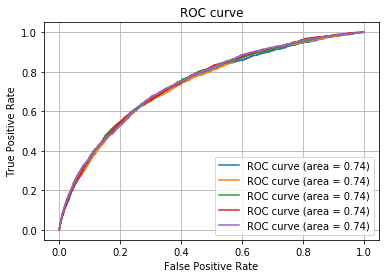

In [53]:
# XをCrossVaridationしてmodelを作成し汎化性能を見る
kf = KFold(n_splits = 5)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    lgb_train_cv = lgb.Dataset(X_train_cv,y_train_cv)
    lgb_eval_cv = lgb.Dataset(X_train_cv, y_train_cv, reference=lgb_train)
    model_cv = lgb.train(lgb_params, lgb_train_cv, valid_sets=lgb_eval_cv)
    y_test_pred_cv = model_cv.predict(X_test_cv)
    make_roc_curve(y_test_cv, y_test_pred_cv)

## Task2 grid search
optuna を使ってみる

In [54]:
# grid searchでなくてoptunaを使ってみる
import optuna
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [55]:
def objective(trial):
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dtest = lgb.Dataset(test_x, label=test_y)
        
    param = {'objective': 'binary', 'metric': 'binary_error', 'verbosity': -1,
             'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
             'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
             'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
             }
    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    if param['boosting_type'] == 'goss':
        param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
        param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])
        # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'binary_error')
    gbm = lgb.train(param, dtrain, valid_sets=[dtest], verbose_eval=False,
                    callbacks=[pruning_callback])
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    auc = roc_auc_score(test_y, pred_labels)
    return 1.0 - auc

In [56]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=100)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2019-03-22 23:04:03,734] Finished a trial resulted in value: 0.5. Current best value is 0.5 with parameters: {'boosting': 'goss', 'num_leaves': 245, 'learning_rate': 4.606833381492849e-05, 'top_rate': 0.014307015449295912, 'other_rate': 0.6099520113100856}.
[I 2019-03-22 23:04:16,069] Finished a trial resulted in value: 0.5. Current best value is 0.5 with parameters: {'boosting': 'goss', 'num_leaves': 245, 'learning_rate': 4.606833381492849e-05, 'top_rate': 0.014307015449295912, 'other_rate': 0.6099520113100856}.
[I 2019-03-22 23:05:05,263] Finished a trial resulted in value: 0.5. Current best value is 0.5 with parameters: {'boosting': 'goss', 'num_leaves': 245, 'learning_rate': 4.606833381492849e-05, 'top_rate': 0.014307015449295912, 'other_rate': 0.6099520113100856}.
[I 2019-03-22 23:05:10,724] Finished a trial resulted in value: 0.49652173913043474. Current best value is 0.49652173913043474 with parameters: {'boosting': 'goss', 'num_leaves': 16, 'learning_rate': 0.083223172944853

Number of finished trials: 100
Best trial:
  Value: 0.48421452924206654
  Params: 
    boosting: goss
    num_leaves: 298
    learning_rate: 0.1713947068943727
    top_rate: 0.6140904851859975
    other_rate: 0.29934324401437934


In [57]:
# best params
best_lgb_params = {'objective': 'binary',
         'metric': 'binary_error', 
         'verbosity': -1,
         'boosting_type':'rf',
         'num_leaves': 283,
         'learning_rate': 0.09625873537358234,
         'subsample': 0.623,
         'colsample_bytree': 0.7,
         'max_depth': 8,
         'seed': 99,
         'bagging_freq': 1,
         'n_jobs': 4}

In [58]:
lgb_train = lgb.Dataset(X,y)

In [59]:
lgb_eval2 = lgb.Dataset(X, y, reference=lgb_train)

In [60]:
best_param_model = lgb.train(best_lgb_params, lgb_train, valid_sets=lgb_eval2)

[1]	valid_0's binary_error: 0.08017
[2]	valid_0's binary_error: 0.07952
[3]	valid_0's binary_error: 0.07978
[4]	valid_0's binary_error: 0.07976
[5]	valid_0's binary_error: 0.07984
[6]	valid_0's binary_error: 0.07988
[7]	valid_0's binary_error: 0.07979
[8]	valid_0's binary_error: 0.07977
[9]	valid_0's binary_error: 0.07992
[10]	valid_0's binary_error: 0.07994
[11]	valid_0's binary_error: 0.07992
[12]	valid_0's binary_error: 0.07985
[13]	valid_0's binary_error: 0.07991
[14]	valid_0's binary_error: 0.07993
[15]	valid_0's binary_error: 0.07992
[16]	valid_0's binary_error: 0.07994
[17]	valid_0's binary_error: 0.07991
[18]	valid_0's binary_error: 0.07992
[19]	valid_0's binary_error: 0.07991
[20]	valid_0's binary_error: 0.07996
[21]	valid_0's binary_error: 0.07995
[22]	valid_0's binary_error: 0.07995
[23]	valid_0's binary_error: 0.07994
[24]	valid_0's binary_error: 0.07995
[25]	valid_0's binary_error: 0.07996
[26]	valid_0's binary_error: 0.07999
[27]	valid_0's binary_error: 0.07998
[28]	valid

In [61]:
y_pred_best_param_train = best_param_model.predict(X)
y_pred_best_param_train.shape

(100000,)

auc0.8055902378565232


0.8055902378565232

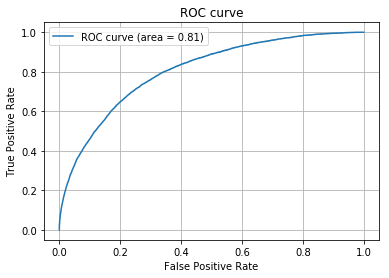

In [62]:
make_roc_curve(y, y_pred_best_param_train)

## best_parameterの方がauc高い

In [63]:
# parameter_table化
params_table = study.trials_dataframe()
params_table

trial_id                state     value             datetime_start  \
                                                                        
0         0  TrialState.COMPLETE  0.500000 2019-03-22 23:03:48.638696   
1         1  TrialState.COMPLETE  0.500000 2019-03-22 23:04:03.739986   
2         2  TrialState.COMPLETE  0.500000 2019-03-22 23:04:16.075961   
3         3  TrialState.COMPLETE  0.496522 2019-03-22 23:05:05.263616   
4         4  TrialState.COMPLETE  0.500000 2019-03-22 23:05:10.740470   
5         5    TrialState.PRUNED  0.083500 2019-03-22 23:05:20.666272   
6         6    TrialState.PRUNED  0.081300 2019-03-22 23:05:25.490277   
7         7    TrialState.PRUNED  0.079950 2019-03-22 23:05:31.211447   
8         8  TrialState.COMPLETE  0.500000 2019-03-22 23:05:38.456668   
9         9  TrialState.COMPLETE  0.491479 2019-03-22 23:06:29.630845   
10       10    TrialState.PRUNED  0.080450 2019-03-22 23:07:23.902850   
11       11    TrialState.PRUNED  0.079750 2019-03-22 23:07:30.701432   
12       12    TrialState.PRUNED  0.079750 2019-03-22 23:07:38.577817   
13       13    TrialState.PRUNED  0.080250 2019-03-22 23:07:43.807423   
14       14    TrialState.PRUNED  0.080000 2019-03-22 23:07:47.389542   
15       15    TrialState.PRUNED  0.079350 2019-03-22 23:07:52.173046   
16       16    TrialState.PRUNED  0.108400 2019-03-22 23:07:54.948420   
17       17    TrialState.PRUNED  0.081400 2019-03-22 23:08:00.497897   
18       18    TrialState.PRUNED  0.078650 2019-03-22 23:08:04.792594   
19       19    TrialState.PRUNED  0.080900 2019-03-22 23:08:11.761933   
20       20    TrialState.PRUNED  0.080850 2019-03-22 23:08:18.468452   
21       21    TrialState.PRUNED  0.081300 2019-03-22 23:08:25.035400   
22       22    TrialState.PRUNED  0.078950 2019-03-22 23:08:28.981924   
23       23    TrialState.PRUNED  0.078850 2019-03-22 23:08:34.359153   
24       24    TrialState.PRUNED  0.078500 2019-03-22 23:08:42.159430   
25       25    TrialState.PRUNED  0.153800 2019-03-22 23:08:47.858194   
26       26    TrialState.PRUNED  0.081400 2019-03-22 23:08:53.531334   
27       27    TrialState.PRUNED  0.139150 2019-03-22 23:08:59.864730   
28       28    TrialState.PRUNED  0.079400 2019-03-22 23:09:05.189321   
29       29    TrialState.PRUNED  0.081600 2019-03-22 23:09:09.571739   
..      ...                  ...       ...                        ...   
70       70    TrialState.PRUNED  0.103600 2019-03-22 23:14:42.015853   
71       71    TrialState.PRUNED  0.153850 2019-03-22 23:14:47.572464   
72       72    TrialState.PRUNED  0.152000 2019-03-22 23:14:53.241022   
73       73    TrialState.PRUNED  0.105100 2019-03-22 23:14:58.631152   
74       74    TrialState.PRUNED  0.134450 2019-03-22 23:15:04.684894   
75       75    TrialState.PRUNED  0.124650 2019-03-22 23:15:10.790689   
76       76    TrialState.PRUNED  0.145550 2019-03-22 23:15:16.672734   
77       77    TrialState.PRUNED  0.145750 2019-03-22 23:15:22.298960   
78       78    TrialState.PRUNED  0.094150 2019-03-22 23:15:28.208890   
79       79    TrialState.PRUNED  0.133450 2019-03-22 23:15:32.827547   
80       80  TrialState.COMPLETE  0.500000 2019-03-22 23:15:39.242953   
81       81    TrialState.PRUNED  0.157000 2019-03-22 23:16:12.611263   
82       82    TrialState.PRUNED  0.100750 2019-03-22 23:16:17.950182   
83       83    TrialState.PRUNED  0.082700 2019-03-22 23:16:23.800534   
84       84    TrialState.PRUNED  0.146550 2019-03-22 23:16:29.242606   
85       85    TrialState.PRUNED  0.139250 2019-03-22 23:16:34.288479   
86       86    TrialState.PRUNED  0.088800 2019-03-22 23:16:39.954068   
87       87    TrialState.PRUNED  0.081900 2019-03-22 23:16:45.650091   
88       88    TrialState.PRUNED  0.152300 2019-03-22 23:16:50.870691   
89       89    TrialState.PRUNED  0.134900 2019-03-22 23:16:55.823364   
90       90    TrialState.PRUNED  0.111200 2019-03-22 23:17:01.861568   
91       91    TrialState.PRUNED  0.129950 2019-03-22 23:17:0

## 問題3 カーネルから考える
mostvoteのカーネルを参考にした

EDAを実行するときに常にデータ内の異常に注意する!

DAYS_BIRTH列の数値は、現在の融資申請に関連して記録されているため、負の値. 

DAYS_BIRTH列の値を-1を乗じて1年の日数で割り特徴量を増やせる年数で見ることができる

異常の処理に規則は設定されてないが、最も安全な方法の1つは、異常を欠損値に設定してから、機械学習の前にそれらを埋め込む（Imputationを使用して）ことである.

年齢カテゴリを5年ごとのビンにカットし,sns.kdeplotでターゲットが1の年齢とターゲットが0の年齢でどんな分布になっているか調べる.

それによって若い年代の方がローンを返済していないことがわかる.

In [64]:
# 'DAYS_BIRTH'に注目する
(df_train_dm['DAYS_BIRTH'] / -365).describe()

count    100000.000000
mean         43.949216
std          11.972648
min          20.517808
25%          34.024658
50%          43.175342
75%          53.934247
max          69.041096
Name: DAYS_BIRTH, dtype: float64

365で割ることで年数にしている.
負の値は問題なく最高70歳以下、最低も20歳以上であり外れ値もないことが分かる

In [65]:
# DAYS_EMPLOYEDに注目する
df_train_dm['DAYS_EMPLOYED'].describe()

count    100000.000000
mean      63967.657050
std      141399.955511
min      -17912.000000
25%       -2756.000000
50%       -1207.000000
75%        -286.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

最大値が1000年であり、正しくないと分かる

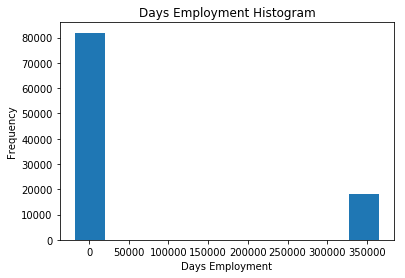

In [66]:
df_train_dm['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

異常値は1件などではなく、5000件もあるようである

異常なクライアントをサブセット化し、それらが他のクライアントよりも高いまたは低いデフォルト率を持つ傾向があるかどうかを確認

In [67]:
anom = df_train_dm[df_train_dm['DAYS_EMPLOYED'] == 365243]
non_anom = df_train_dm[df_train_dm['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.59% of loans
The anomalies default on 5.32% of loans
There are 18048 anomalous days of employment


異常はデフォルト率が低い

このときに最も安全なのは異常を欠損値に設定してから、学習の前に埋め込むこと

There are 9274 anomalies in the test data out of 48744 entries


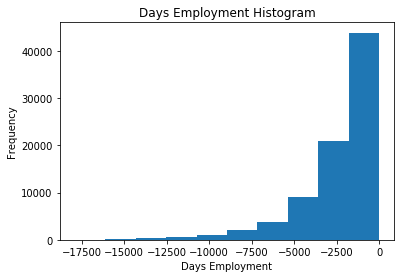

In [68]:
# Create an anomalous flag column
df_train_dm['DAYS_EMPLOYED_ANOM'] = df_train_dm["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_train_dm['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_train_dm['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

# test-dataにも適応する
df_test_dm['DAYS_EMPLOYED_ANOM'] = df_test_dm["DAYS_EMPLOYED"] == 365243
df_test_dm["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_test_dm["DAYS_EMPLOYED_ANOM"].sum(), len(df_test_dm)))

次に相関係数を調べる

相関係数の一般的解釈

.00-.19 “very weak”

.20-.39 “weak”

.40-.59 “moderate”

.60-.79 “strong”

.80-1.0 “very strong”

In [69]:
# Find correlations with the target and sort
correlations = df_train_dm.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_EMPLOYED                     0.070863
DAYS_BIRTH                        0.082332
TARGET                            1.000000
FLAG_DOCUMENT_12                       NaN
FLAG_MOBIL                             NaN
CODE_GENDER_nan                        NaN
FLAG_OWN_CAR_nan                       NaN
FLAG_OWN_REALTY_nan                    NaN
NAME_CONTRACT_TYPE_nan                 NaN
NAME_EDUCATION_TYPE_nan                NaN
NAME_FAMILY_STATUS_nan                 NaN
NAME_HOUSING_TYPE_nan                  NaN
NAME_INCOME_TYPE_nan                   NaN
ORGANIZATION_TYPE_nan                  NaN
WEEKDAY_APPR_PROCESS_START_nan         NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.168503
EXT_SOURCE_2                           -0.162147
EXT_SOURCE_1                           -0.155050
NAME_EDUCATION_TYPE_Higher education   -0.056918
CODE_GENDER_F                          -0.054629
NAME_INCOME_TYPE_Pensi

In [70]:
# Find the correlation of the positive days since birth and target
df_train_dm['DAYS_BIRTH'] = abs(df_train_dm['DAYS_BIRTH'])
df_train_dm['DAYS_BIRTH'].corr(df_train_dm['TARGET'])

-0.08233216386640957

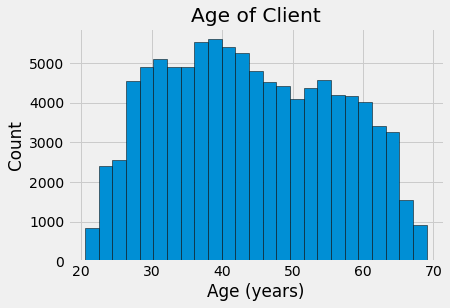

In [71]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(df_train_dm['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



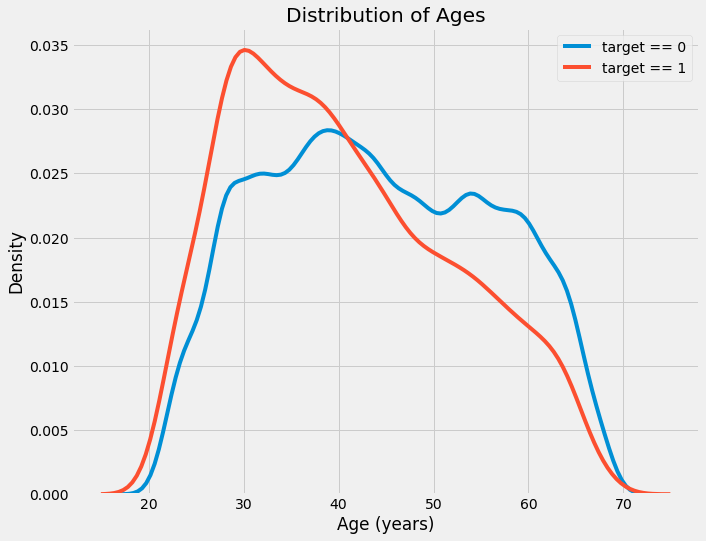

In [72]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_train_dm.loc[df_train_dm['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_train_dm.loc[df_train_dm['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

target=1,すなわち返済出来なかった群ではピークが若いことが分かる

In [73]:
# Age information into a separate dataframe
age_data = df_train_dm[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
170199,0.0,18240,49.972603,"(45.0, 50.0]"
92577,0.0,17275,47.328767,"(45.0, 50.0]"
187905,0.0,11193,30.665753,"(30.0, 35.0]"
71664,0.0,20699,56.709589,"(55.0, 60.0]"
257547,1.0,15192,41.621918,"(40.0, 45.0]"
129400,0.0,10058,27.556164,"(25.0, 30.0]"
199475,0.0,22082,60.498630,"(60.0, 65.0]"
243631,1.0,14205,38.917808,"(35.0, 40.0]"
277214,0.0,15050,41.232877,"(40.0, 45.0]"
94116,0.0,15096,41.358904,"(40.0, 45.0]"


In [74]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123841,8532.479067,23.376655
"(25.0, 30.0]",0.113358,10155.856969,27.824266
"(30.0, 35.0]",0.105023,11855.182491,32.479952
"(35.0, 40.0]",0.088294,13705.010894,37.547975
"(40.0, 45.0]",0.077849,15499.832863,42.465296
"(45.0, 50.0]",0.070189,17328.457145,47.475225
"(50.0, 55.0]",0.064040,19194.941564,52.588881
"(55.0, 60.0]",0.053731,20996.582684,57.524884
"(60.0, 65.0]",0.053009,22782.211252,62.417017


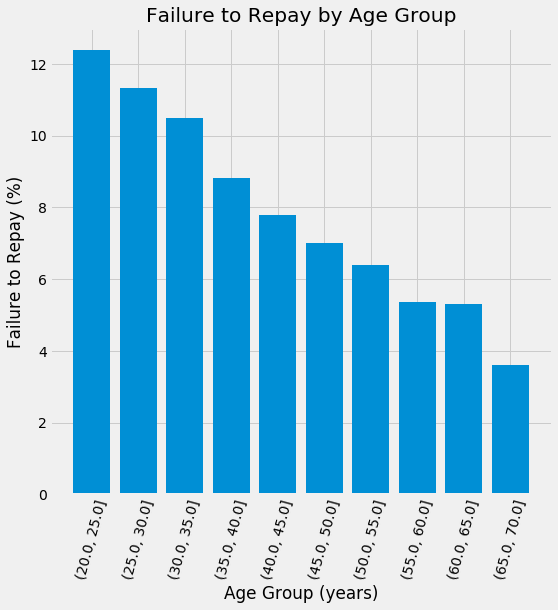

In [75]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

5歳刻みでグループにしたところ若い人の方が返済しない傾向が顕著にみられた

## 問題4 高い汎化性能のモデル

複数のモデルを実行してkFoldの高いモデルが高いモデルといえるのでいろいろなモデルで試してみる

In [14]:
#欠損値を平均値で埋めて処理する
df_target = df_train_dm["TARGET"]
df_train_test_dm = df_train_dm.drop("TARGET",axis=1).append(df_test_dm)
df_train_test_dm2 = df_train_test_dm.fillna(df_train_test_dm.mean())


In [15]:
#objectdataの欠損がある列は消す
df_train_test_dm3 = df_train_test_dm2.dropna(how='any', axis=1)

In [16]:
# split the concatenated dataset into the train dataset and the test dataset

df_train_dm4 = df_train_test_dm3[0: df_train.shape[0]].copy()
df_train_dm4["TARGET"] = df_target
print("train_ shape is", df_train_dm4.shape)

df_test_dm4 = df_train_test_dm3[df_train.shape[0]:].copy()
print("test_ shape is", df_test_dm4.shape)

train_ shape is (100000, 261)
test_ shape is (48744, 260)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [18]:
# LogisticRegression
lr = LogisticRegression()

In [19]:
# SupportVectorMachine
svc = SVC(gamma='scale')

In [20]:
from sklearn.model_selection import KFold

def pipline_Kfold(model, data, target_value, feature_value, positive_label, normalization=True, plot=True):
    """
    Parameter
    ---------------
    model : the model of method
    target_value :train data
    feature_value : objective valuable
    normalization :name, True= standardize　False= no standardize
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    results = []
    
    X = data.drop([target_value], axis=1).values
    y = data[target_value].values
    
    kf = KFold(n_splits=10)
    kf.get_n_splits(X)
    
    for train_index, test_index in kf.split(X, y):
        # split the dataset learning data and test data        
        train_feature, test_feature = X[train_index], X[test_index]
        train_target, test_target = y[train_index], y[test_index]
        
        print("The number of statistical universe data：{}　The number of learning data：{}　The number of test data：{}".format(len(data), len(df_train), len(df_test)))

        #　standardlization of features
        if normalization == True:
            scaler = StandardScaler()
            scaler.fit(train_feature)
            train_feature = scaler.transform(train_feature)
            scaler.fit(test_feature)
            test_feature = scaler.transform(test_feature)

        # learning and predict
        model.fit(train_feature, train_target)
        prediction = model.predict_proba(test_feature)

        # compute roc
        fpr, tpr, thresholds = metrics.roc_curve(test_target, prediction[:,1], pos_label=positive_label)
        
        result = metrics.auc(fpr, tpr)
        results.append(result)
        # plot roc
        if plot == True:
            # define Initial setting 
            fig, ax = plt.subplots(figsize=(6, 6))
            fig.patch.set_facecolor('blue')
            fig.patch.set_alpha(0.1)
            ax.patch.set_facecolor('white')
            ax.patch.set_alpha(1)

            plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
            plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
            plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.ylim([0.0, 1.0])
            plt.xlim([0.0, 1.0])
            plt.show()
            
        print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

    return results, prediction, fpr, tpr, thresholds



The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


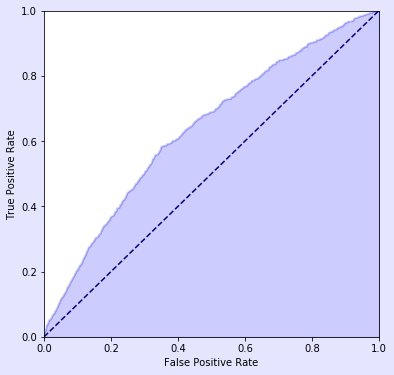

AUC=0.63740
The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


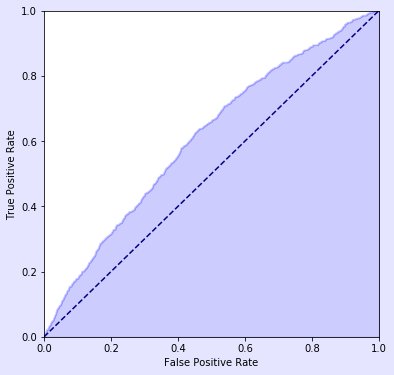

AUC=0.60886
The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


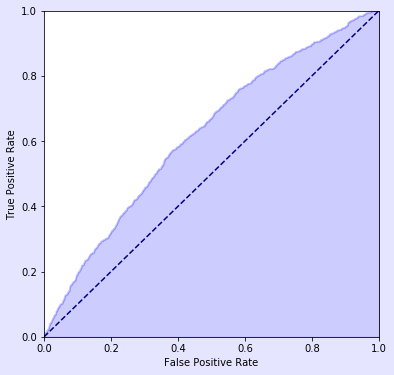

AUC=0.61974
The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


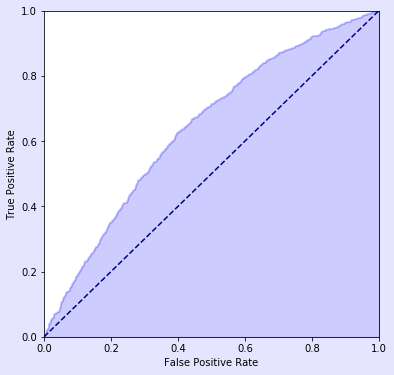

AUC=0.64144
The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


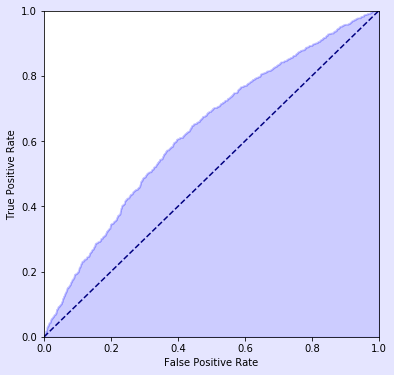

AUC=0.62840
The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


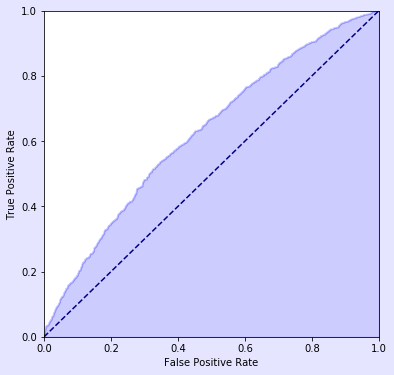

AUC=0.62431
The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


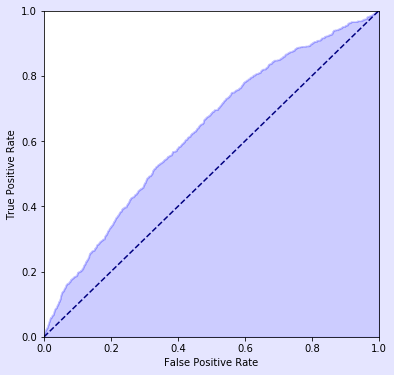

AUC=0.62648
The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


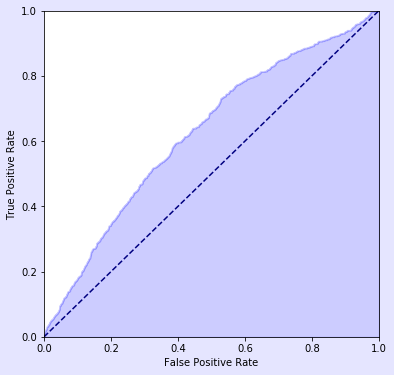

AUC=0.62431
The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


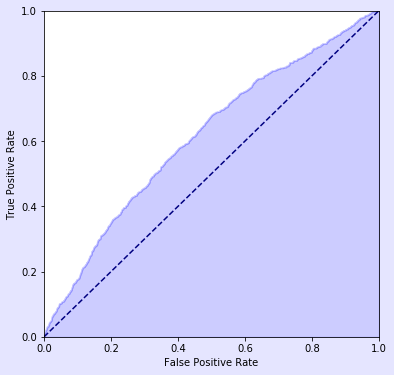

AUC=0.61315
The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


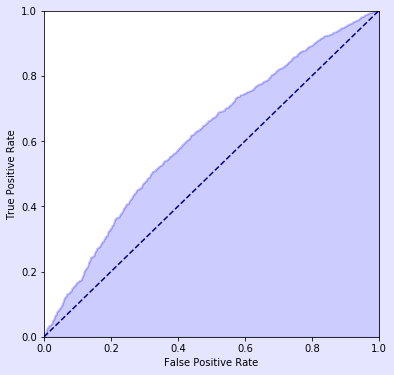

AUC=0.61333
[0.6374033008121148, 0.608857699286044, 0.6197445306545931, 0.6414411951745018, 0.6283973269300773, 0.6243064039342592, 0.6264785792654821, 0.6243091891891892, 0.6131457165246146, 0.6133252893579332]


In [21]:
results, prediction, fpr, tpr, thresholds = pipline_Kfold(lr, df_train_dm4 , "TARGET", df_test_dm4.columns, 1, False)

print(results)

In [ ]:
results, prediction, fpr, tpr, thresholds = pipline_Kfold(svc, df_train_dm4 , "TARGET", df_test_dm4.columns, 1, False)

print(results)

The number of statistical universe data：100000　The number of learning data：100000　The number of test data：48744


kfoldで汎化性能を測定するのでLogisticRegressionよりもlightgbmの方が汎化性能が高いモデルといえる